## 1. Annular Domain Problem

### 1. Governing Equation

The **Laplace equation** in 2D Cartesian coordinates is:

$$
\nabla^2 \phi = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = 0
$$

where $\phi(x,y)$ is the scalar potential.

---

### 2. Domain

- **Inner boundary:** Circle of radius $a$  
- **Outer boundary:** Possibly corrugated circle with radius

$$
R_{\text{outer}}(\theta) = R_0 \big( 1 + \epsilon \cos(m \theta) \big)
$$

where  
$R_0$ is the base outer radius,  
$\epsilon$ is the corrugation amplitude,  
$m$ is the corrugation mode number,  
and $\theta = \arctan2(y, x)$ is the polar angle.

The computational domain is the annular region:

$$
a \le r \le R_{\text{outer}}(\theta)
$$

with $r = \sqrt{x^2 + y^2}$.

---

### 3. Boundary Conditions

- **Inner boundary (Dirichlet):**

$$
\phi(r=a) = V_{\text{in}}
$$

- **Outer boundary (Dirichlet, possibly non-uniform):**

$$
\phi(r=R_{\text{outer}}(\theta)) = V_0 + V_1 \cos(k \theta)
$$

where $V_0, V_1$ are constants and $k$ is the harmonic mode.

---

### 4. Numerical Method

- Use a **finite-difference grid** in the rectangular computational domain containing the annulus.
- Apply **Gauss-Seidel or SOR iteration** to solve for interior points:

$$
\phi_{i,j}^{\text{new}} = \phi_{i,j}^{\text{old}} + \omega \left( \frac{\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1}}{N_{\text{neighbors}}} - \phi_{i,j}^{\text{old}} \right)
$$

where $\omega$ is the relaxation factor, and $N_{\text{neighbors}}$ is the number of valid neighbors inside the domain.

---

### 5. Analytical Solution (Circular Annulus)

For a **circular annulus** ($\epsilon = 0$), the solution can be obtained by **separation of variables** in polar coordinates:

$$
\phi(r,\theta) = \phi_0(r) + \phi_k(r)\cos(k \theta)
$$

with

$$
\phi_0(r) = \frac{V_{\text{in}}\ln(R_0/r) + V_0 \ln(r/a)}{\ln(R_0/a)}, \quad
\phi_k(r) = A_k r^k + B_k r^{-k}, \quad
B_k = -A_k a^{2k}, \quad
A_k = \frac{V_1}{R_0^k - a^{2k}/R_0^k}.
$$


L2 error (Nx=200): 2.220e-02, iterations : 6195
N=50, L2 error=3.830e-02, Iterations : 713
N=100, L2 error=1.910e-02, Iterations : 2148
N=200, L2 error=2.220e-02, Iterations : 6195
N=400, L2 error=7.893e-02, Iterations : 10000
Estimated orders: [np.float64(1.0041483133053162), np.float64(-0.21750766951604228), np.float64(-1.829773746699616)]


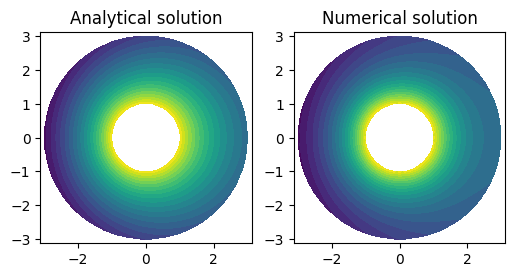

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. Finite-Difference Solver for Laplace's Equation
# ===============================
def solve_laplace_annulus(Nx, Ny, a, R0, eps, m, V_in, V0, V1, k,
                          max_iter=10000, tol=1e-5, omega=1.0):
    """
    Solve Laplace's equation in a corrugated annulus using a finite-difference
    Gauss-Seidel (SOR) method.

    Parameters:
    -----------
    Nx, Ny : int
        Number of grid points in x and y directions.
    a : float
        Inner radius of the annulus (circle).
    R0 : float
        Base outer radius (before corrugation).
    eps : float
        Corrugation amplitude (fraction of R0).
    m : int
        Corrugation mode number (cos(m*theta) term in boundary shape).
    V_in : float
        Potential at the inner boundary (constant).
    V0, V1 : float
        Constants in the outer boundary potential V0 + V1 cos(kθ).
    k : int
        Harmonic mode number for outer boundary potential variation.
    max_iter : int
        Maximum solver iterations.
    tol : float
        Convergence tolerance (max change between iterations).
    omega : float
        Relaxation parameter (1.0 = Gauss-Seidel, >1.0 = SOR).

    Returns:
    --------
    x, y : 1D arrays
        Grid coordinates.
    phi : 2D array
        Potential values on the grid.
    domain : 2D boolean array
        True inside the annulus, False outside.
    """
    # --- 1. Define rectangular computational domain ---
    pad = 0.12  # extra space around outer boundary
    xmax = R0*(1+abs(eps)) + pad
    xmin, ymin, ymax = -xmax, -xmax, xmax
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing='xy')

    # --- 2. Convert to polar coordinates ---
    R = np.sqrt(X**2 + Y**2)        # radial coordinate
    Theta = np.arctan2(Y, X)        # angular coordinate

    # --- 3. Define outer boundary radius (possibly corrugated) ---
    R_outer = R0*(1 + eps*np.cos(m*Theta))

    # --- 4. Define computational mask for points inside the annulus ---
    domain = (R >= a) & (R <= R_outer)

    # --- 5. Identify points near the inner and outer boundaries ---
    dist_to_inner = np.abs(R - a)
    dist_to_outer = np.abs(R - R_outer)
    th = 0.6 * max(dx, dy)  # tolerance for detecting boundary points

    is_inner_bc = domain & (dist_to_inner <= th)
    is_outer_bc = domain & (dist_to_outer <= th)

    # --- 6. Initialize potential field with BC values ---
    phi = np.zeros_like(X)
    phi[is_inner_bc] = V_in
    phi[is_outer_bc] = V0 + V1 * np.cos(k*Theta[is_outer_bc])

    # --- 7. Identify interior points (no fixed BCs) ---
    interior = domain & ~(is_inner_bc | is_outer_bc)
    boundary_mask = is_inner_bc | is_outer_bc

    # --- 8. Gauss-Seidel / SOR iteration ---
    it = 0
    max_change = 1.0
    while it < max_iter and max_change > tol:
        it += 1
        phi_old = phi.copy()

        # Neighbor values (shift arrays in each direction)
        left  = np.roll(phi,  1, axis=1)
        right = np.roll(phi, -1, axis=1)
        up    = np.roll(phi,  1, axis=0)
        down  = np.roll(phi, -1, axis=0)

        # Masks for valid neighbor points
        left_mask  = np.roll(domain | boundary_mask,  1, axis=1)
        right_mask = np.roll(domain | boundary_mask, -1, axis=1)
        up_mask    = np.roll(domain | boundary_mask,  1, axis=0)
        down_mask  = np.roll(domain | boundary_mask, -1, axis=0)

        # Sum & count of valid neighbors for each interior point
        neighbor_sum = (left  * left_mask +
                        right * right_mask +
                        up    * up_mask +
                        down  * down_mask)
        neighbor_count = (left_mask.astype(int) +
                          right_mask.astype(int) +
                          up_mask.astype(int) +
                          down_mask.astype(int))

        # Only update interior points with ≥1 valid neighbor
        valid = (interior) & (neighbor_count > 0)
        avg = np.zeros_like(phi)
        avg[valid] = neighbor_sum[valid] / neighbor_count[valid]

        # SOR update
        phi[valid] = phi[valid] + omega * (avg[valid] - phi[valid])

        # Enforce BCs again (they might be overwritten by neighbor shifts)
        phi[is_inner_bc] = V_in
        phi[is_outer_bc] = V0 + V1 * np.cos(k*Theta[is_outer_bc])

        # Compute max change for convergence check
        max_change = np.nanmax(np.abs(phi - phi_old))

    return x, y, phi, domain, it

# ===============================
# 2. Analytical Solution (Circular Annulus Only)
# ===============================
def analytic_circular_annulus(a, R0, V_in, V0, V1, k, X, Y):
    """
    Exact solution for Laplace's equation in a circular annulus with BCs:
        phi(a) = V_in
        phi(R0,θ) = V0 + V1 cos(k θ)
    Uses separation of variables in polar coordinates.
    """
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    phi = np.zeros_like(R)

    # --- n=0 (constant) mode ---
    denom0 = np.log(R0/a)
    phi0 = (V_in*np.log(R0/R) + V0*np.log(R/a)) / denom0
    phi += phi0

    # --- n=k harmonic mode ---
    Ak = V1 / (R0**k - a**(2*k) / R0**k)
    Bk = -Ak * a**(2*k)
    phi_k = (Ak*R**k + Bk*R**(-k)) * np.cos(k*Theta)
    phi += phi_k

    return phi

# ===============================
# 3. Compare Numerical and Analytical Solutions
# ===============================
# Physical parameters
a = 1.0       # inner radius
R0 = 3.0      # outer radius (base, before corrugation)
eps = 0.0     # corrugation amplitude (set 0 for analytic comparison)
m = 0         # corrugation mode number (irrelevant if eps=0)
V_in = 1.0    # inner BC potential
V0 = 0.0      # outer BC constant part
V1 = 0.2      # outer BC cosine amplitude
k = 1         # outer BC harmonic mode number

# Solve numerically
Nx = Ny = 200
x, y, phi_num, domain, it = solve_laplace_annulus(Nx, Ny, a, R0, eps, m, V_in, V0, V1, k)
X, Y = np.meshgrid(x, y, indexing='xy')

# Get exact solution
phi_exact = analytic_circular_annulus(a, R0, V_in, V0, V1, k, X, Y)

# Compute L2 error over domain
mask = domain
error = phi_num - phi_exact
L2_err = np.sqrt(np.nanmean((error[mask])**2))
print(f"L2 error (Nx={Nx}): {L2_err:.3e}, iterations : {it}")

# ===============================
# 4. Grid Refinement Study
# ===============================
Ns = [50, 100, 200, 400]
errors = []
for N in Ns:
    x, y, phi_num, domain, it = solve_laplace_annulus(N, N, a, R0, eps, m, V_in, V0, V1, k)
    X, Y = np.meshgrid(x, y, indexing='xy')
    phi_exact = analytic_circular_annulus(a, R0, V_in, V0, V1, k, X, Y)
    mask = domain
    L2_err = np.sqrt(np.nanmean((phi_num[mask] - phi_exact[mask])**2))
    errors.append(L2_err)
    print(f"N={N}, L2 error={L2_err:.3e}, Iterations : {it}")

# Estimate convergence order
orders = [np.log(errors[i-1]/errors[i])/np.log(2) for i in range(1,len(errors))]
print("Estimated orders:", orders)

# ===============================
# 5. Plot Numerical vs Analytical
# ===============================
phi_exact_masked = np.where(domain, phi_exact, np.nan)
phi_num_masked = np.where(domain, phi_num, np.nan)

plt.figure(figsize=(6,5))
plt.subplot(1,2,1)
plt.contourf(X, Y, phi_exact_masked, 20, cmap='viridis')
plt.title("Analytical solution")
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.contourf(X, Y, phi_num_masked, 20, cmap='viridis')
plt.title("Numerical solution")
plt.gca().set_aspect('equal')
plt.show()


## 2. Corrugated Outer Boundary Problem

**Governing Equation:**
$$
\nabla^2 \Phi(r, \theta) = 0
$$

**Domain:**
- Inner boundary: Circle of radius $R_{\text{in}}$  
- Outer boundary: Corrugated shape defined by:
$$
r(\theta) = R_0 \left[ 1 + \varepsilon \cos(m\theta) \right]
$$
where:
- $R_0$ = mean outer radius
- $\varepsilon$ = corrugation amplitude
- $m$ = number of corrugation cycles

**Boundary Conditions:**
- Inner boundary ($r = R_{\text{in}}$):  
  $\Phi = V_{\text{in}}$
- Outer boundary ($r = r(\theta)$):  
  $\Phi = V_{\text{out}}$

**Objective:**  
Determine the potential $\Phi(r,\theta)$ inside the domain.


SOR finished: N=50, iterations=181, final max_change=9.88e-07, interior nodes=1288


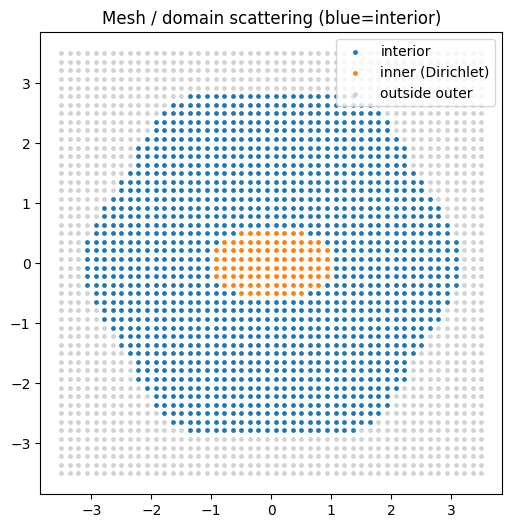

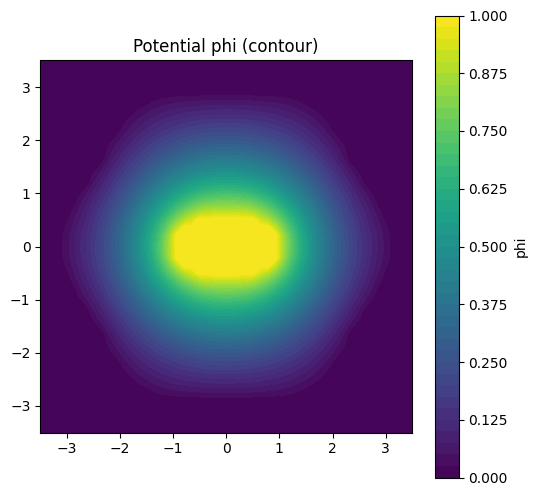

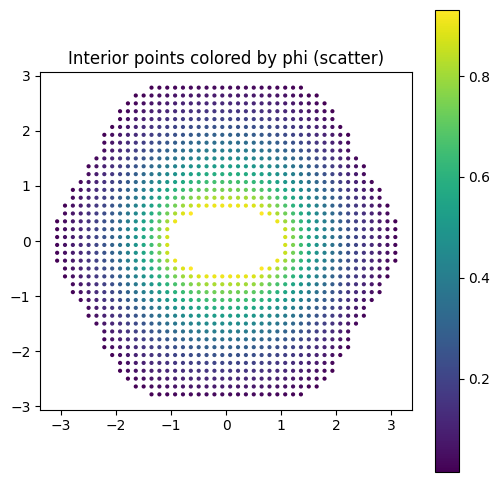

Solving N=200 ...
 N=200 iter=200 max_change=6.867e-04
 N=200 iter=400 max_change=2.952e-04
 N=200 iter=600 max_change=1.481e-04
 N=200 iter=800 max_change=7.440e-05
 N=200 iter=1000 max_change=3.712e-05
 N=200 iter=1200 max_change=1.842e-05
 N=200 iter=1400 max_change=9.115e-06
 N=200 iter=1600 max_change=4.500e-06
 N=200 iter=1800 max_change=2.219e-06
 N=200 iter=2000 max_change=1.093e-06
SOR finished: N=200, iterations=2026, final max_change=9.97e-07, interior nodes=21328
Solving N=100 ...
 N=100 iter=200 max_change=3.290e-04
 N=100 iter=400 max_change=2.071e-05
 N=100 iter=600 max_change=1.262e-06
SOR finished: N=100, iterations=617, final max_change=9.95e-07, interior nodes=5288
Solving N=50 ...
SOR finished: N=50, iterations=181, final max_change=9.88e-07, interior nodes=1288
Compare coarse N=50 vs fine N=200: L2 error = 8.920e-03
Compare coarse N=100 vs fine N=200: L2 error = 4.413e-03
Errors (coarse->fine): [np.float64(0.008920376018892524), np.float64(0.004413113371589478)]
Es

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

# -----------------------
# Problem / geometry params
# -----------------------
a = 1.0          # inner ellipse semi-major (x)
b = 0.6          # inner ellipse semi-minor (y)

R0 = 3.0         # base outer radius
eps = 0.05       # corrugation amplitude (set to 0.05 per your case)
m = 6            # corrugation mode (choose 4..8 typical)

V_inner = 1.0
V_outer = 0.0

L = 3.5          # half-size of square computational box [-L, L]^2

# SOR parameters
omega = 1.5
tol = 1e-6
max_iter = 20000

# -----------------------
# Geometry helper funcs
# -----------------------
def outer_radius(theta):
    """Star / corrugated outer radius r(theta)."""
    return R0 * (1.0 + eps * np.cos(m * theta))

def inside_outer(x, y):
    """True if point (x,y) lies inside the corrugated outer boundary."""
    r = np.hypot(x, y)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)
    return r <= outer_radius(theta)

def inside_inner_ellipse(x, y):
    """True if point lies inside the inner ellipse (Dirichlet=V_inner)."""
    return (x/a)**2 + (y/b)**2 <= 1.0

# -----------------------
# Grid / domain generation
# -----------------------
def make_grid(N):
    """Return x, y 1D arrays and 2D meshgrids X,Y and masks for interior, inner boundary, outer boundary."""
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y, indexing='xy')

    inner_mask = inside_inner_ellipse(X, Y)        # points inside inner electrode
    outer_mask = ~inside_outer(X, Y)               # points outside outer boundary (treated as outer dirichlet region)
    # interior valid points are those inside outer AND outside inner
    interior_mask = (~inner_mask) & (~outer_mask)

    return x, y, X, Y, interior_mask, inner_mask, outer_mask, dx, dy

# -----------------------
# SOR solver (explicit loops)
# -----------------------
def solve_sor(N, omega=1.5, tol=1e-6, max_iter=20000):
    x, y, X, Y, interior_mask, inner_mask, outer_mask, dx, dy = make_grid(N)
    phi = np.zeros_like(X)

    # Initialize Dirichlet BCs
    phi[inner_mask] = V_inner
    phi[outer_mask] = V_outer

    # Count interior nodes
    n_interior = np.count_nonzero(interior_mask)
    if n_interior == 0:
        raise RuntimeError("No interior nodes found — check geometry or N/L.")

    # SOR iteration
    it = 0
    max_change = 1.0
    Ny, Nx = X.shape
    while it < max_iter and max_change > tol:
        it += 1
        max_change = 0.0
        # sweep over grid interior points (avoid boundaries of array)
        # using indexing [j,i] => j over rows (y), i over cols (x)
        for j in range(1, Ny-1):
            for i in range(1, Nx-1):
                if interior_mask[j, i]:
                    # 5-point Laplacian steady-state => average of 4 neighbors
                    new_val = 0.25 * (phi[j+1, i] + phi[j-1, i] + phi[j, i+1] + phi[j, i-1])
                    diff = new_val - phi[j, i]
                    phi[j, i] += omega * diff
                    if abs(diff) > max_change:
                        max_change = abs(diff)
        # optionally re-enforce BCs (shouldn't change but safe)
        phi[inner_mask] = V_inner
        phi[outer_mask] = V_outer

        if it % 200 == 0:
            print(f" N={N} iter={it} max_change={max_change:.3e}")
    print(f"SOR finished: N={N}, iterations={it}, final max_change={max_change:.2e}, interior nodes={n_interior}")
    return x, y, X, Y, phi, interior_mask, inner_mask, outer_mask, dx, dy

# -----------------------
# Bilinear interpolation (coarse -> fine)
# -----------------------
def bilinear_interpolate(coarse_phi, x_coarse, y_coarse, x_fine, y_fine):
    """Interpolate coarse_phi defined on (x_coarse, y_coarse) to mesh (x_fine, y_fine).
       All grids are uniform and axis-aligned. Returns array shaped (len(y_fine), len(x_fine)).
    """
    Nx_c = len(x_coarse); Ny_c = len(y_coarse)
    dx = x_coarse[1] - x_coarse[0]; dy = y_coarse[1] - y_coarse[0]
    xmin, ymin = x_coarse[0], y_coarse[0]
    # Prepare output
    out = np.empty((len(y_fine), len(x_fine)))
    for j_f, yf in enumerate(y_fine):
        # fractional index in coarse grid (along y)
        v = (yf - ymin) / dy
        j0 = int(np.floor(v))
        t = v - j0
        # clamp
        if j0 < 0:
            j0 = 0; t = 0.0
        if j0 >= Ny_c - 1:
            j0 = Ny_c - 2; t = 1.0
        for i_f, xf in enumerate(x_fine):
            u = (xf - xmin) / dx
            i0 = int(np.floor(u))
            s = u - i0
            if i0 < 0:
                i0 = 0; s = 0.0
            if i0 >= Nx_c - 1:
                i0 = Nx_c - 2; s = 1.0
            # corners: (j0,i0), (j0,i0+1), (j0+1,i0), (j0+1,i0+1)
            f00 = coarse_phi[j0, i0]
            f10 = coarse_phi[j0, i0+1]
            f01 = coarse_phi[j0+1, i0]
            f11 = coarse_phi[j0+1, i0+1]
            # bilinear
            out[j_f, i_f] = (1-s)*(1-t)*f00 + s*(1-t)*f10 + (1-s)*t*f01 + s*t*f11
    return out

# -----------------------
# L2 error restricted to interior (fine) mask
# -----------------------
def compute_L2_error(phi_fine, phi_coarse_interp, interior_mask_fine):
    diff = phi_coarse_interp - phi_fine
    # consider only interior points
    vals = diff[interior_mask_fine]
    # if no interior points: return nan
    if vals.size == 0:
        return np.nan
    L2 = np.sqrt(np.mean(vals**2))
    return L2

# -----------------------
# grid refinement driver
# -----------------------
def grid_refinement(N_list):
    # solve on finest first to act as reference
    N_sorted = sorted(N_list, reverse=True)
    solutions = {}
    for N in N_sorted:
        print(f"Solving N={N} ...")
        x, y, X, Y, phi, interior_mask, inner_mask, outer_mask, dx, dy = solve_sor(N, omega=omega, tol=tol, max_iter=max_iter)
        solutions[N] = (x, y, X, Y, phi, interior_mask)
    N_ref = N_sorted[0]
    x_ref, y_ref, X_ref, Y_ref, phi_ref, interior_ref = solutions[N_ref]

    errors = []
    for N in sorted(N_list):
        if N == N_ref:
            continue
        x_c, y_c, Xc, Yc, phi_c, interior_c = solutions[N]
        # interpolate coarse phi_c onto fine (x_ref,y_ref)
        phi_c_on_ref = bilinear_interpolate(phi_c, x_c, y_c, x_ref, y_ref)
        err = compute_L2_error(phi_ref, phi_c_on_ref, interior_ref)
        print(f"Compare coarse N={N} vs fine N={N_ref}: L2 error = {err:.3e}")
        errors.append(err)
    # estimate order (between successive errors)
    rates = []
    for i in range(len(errors)-1):
        e1 = errors[i]; e2 = errors[i+1]
        r = float(sorted(N_list)[i+1]) / float(sorted(N_list)[i])
        if e1 > 0 and e2 > 0:
            order = np.log(e1/e2) / np.log(r)
        else:
            order = np.nan
        rates.append(order)
    return errors, rates, (x_ref, y_ref, X_ref, Y_ref, phi_ref, interior_ref)

# -----------------------
# Plot utilities
# -----------------------
def plot_mesh_scatter(X, Y, interior_mask, inner_mask, outer_mask):
    plt.figure(figsize=(6,6))
    plt.scatter(X[interior_mask], Y[interior_mask], s=6, c='tab:blue', label='interior')
    plt.scatter(X[inner_mask], Y[inner_mask], s=6, c='tab:orange', label='inner (Dirichlet)')
    plt.scatter(X[outer_mask], Y[outer_mask], s=6, c='lightgray', label='outside outer')
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.title('Mesh / domain scattering (blue=interior)')
    plt.show()

def plot_solution(x, y, phi, interior_mask):
    plt.figure(figsize=(6,6))
    plt.contourf(x, y, phi, levels=40, cmap='viridis')
    plt.colorbar(label='phi')
    plt.gca().set_aspect('equal')
    plt.title('Potential phi (contour)')
    plt.show()
    # overlay mesh scatter
    X, Y = np.meshgrid(x, y, indexing='xy')
    plt.figure(figsize=(6,6))
    plt.scatter(X[interior_mask], Y[interior_mask], s=4, c=phi[interior_mask], cmap='viridis')
    plt.gca().set_aspect('equal')
    plt.title('Interior points colored by phi (scatter)')
    plt.colorbar()
    plt.show()

# -----------------------
# Main run
# -----------------------
if __name__ == "__main__":
    # Choose grid sizes for refinement test
    N_list = [50, 100, 200]

    # First solve one grid and show mesh + solution
    N0 = N_list[0]
    x0, y0, X0, Y0, phi0, interior0, inner0, outer0, dx0, dy0 = solve_sor(N0, omega=omega, tol=tol, max_iter=20000)
    # plot domain scatter
    plot_mesh_scatter(X0, Y0, interior0, inner0, outer0)
    # plot solution
    plot_solution(x0, y0, phi0, interior0)

    # Do refinement study (fine -> coarse internally handled)
    errors, rates, ref_data = grid_refinement(N_list)
    print("Errors (coarse->fine):", errors)
    print("Estimated orders:", rates)


## 3. Star-Shaped Domain Problem

**Governing Equation:**
$$
\nabla^2 \Phi(r, \theta) = 0
$$

**Domain:**
- Outer boundary: Star-shaped curve given by:
$$
r(\theta) = R_s \left[ 1 + a \cos(n\theta) \right]
$$
where:
- $R_s$ = base radius
- $a$ = star pointiness parameter ($0 < a < 1$)
- $n$ = number of star points

- Inner boundary: Circle of radius $R_{\text{in}}$ (optional, can be solid star if omitted)

**Boundary Conditions:**
- Outer boundary ($r = r(\theta)$):  
  $\Phi = V_{\text{out}}$
- Inner boundary ($r = R_{\text{in}}$, if present):  
  $\Phi = V_{\text{in}}$

**Objective:**  
Solve for $\Phi(r,\theta)$ in the star-shaped region.

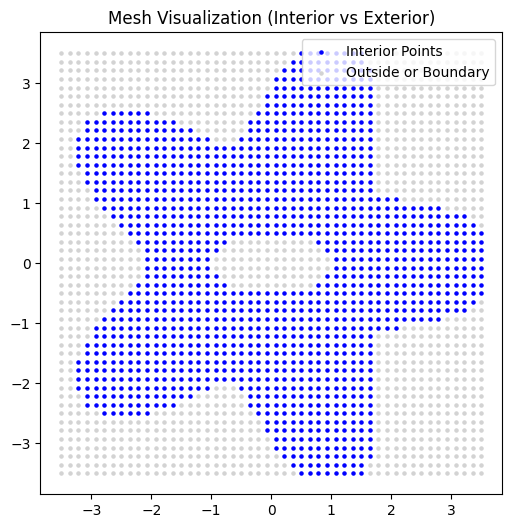

N=50: converged in 60 iterations, max diff=8.93e-06


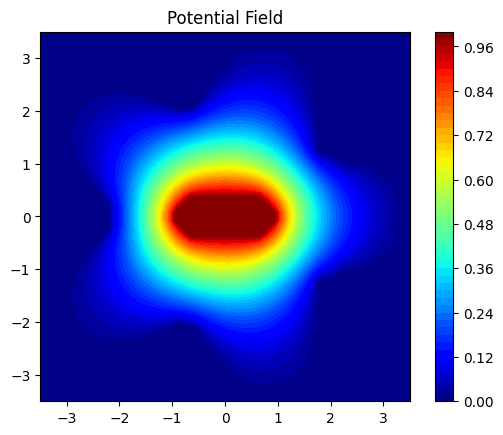

N=200: converged in 624 iterations, max diff=9.91e-06
N=100: converged in 196 iterations, max diff=9.73e-06
N=50: converged in 60 iterations, max diff=8.93e-06
Errors: [np.float64(0.10948896827966226), np.float64(0.06422714930370432)]
Convergence rates: [np.float64(0.7695303467738821)]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Geometry definitions
# ------------------------------
def outer_radius(theta):
    """Outer star-shaped boundary radius."""
    R0 = 3.0
    r1 = 0.3
    m = 5
    return R0 * (1 + r1 * np.cos(m * theta))

def inside_outer_boundary(x, y):
    """Check if point is inside outer star."""
    r = np.sqrt(x**2 + y**2)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)
    return r <= outer_radius(theta)

def inside_inner_boundary(x, y):
    """Check if point is inside inner ellipse."""
    a, b = 1.0, 0.5
    return (x/a)**2 + (y/b)**2 <= 1.0

# ------------------------------
# Mesh generation
# ------------------------------
def generate_domain(N):
    L = 3.5
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)
    X, Y = np.meshgrid(x, y, indexing="xy")

    interior = np.zeros_like(X, dtype=bool)
    for i in range(N):
        for j in range(N):
            if inside_outer_boundary(X[i,j], Y[i,j]) and not inside_inner_boundary(X[i,j], Y[i,j]):
                interior[i,j] = True
    return x, y, X, Y, interior

# ------------------------------
# Mesh visualization
# ------------------------------
def plot_mesh(X, Y, interior):
    plt.figure(figsize=(6,6))
    plt.scatter(X[interior], Y[interior], s=5, color='blue', label='Interior Points')
    plt.scatter(X[~interior], Y[~interior], s=5, color='lightgray', label='Outside or Boundary')
    plt.gca().set_aspect('equal')
    plt.title("Mesh Visualization (Interior vs Exterior)")
    plt.legend()
    plt.show()

# ------------------------------
# Laplace solver (SOR)
# ------------------------------
def solve_laplace(N, omega=1.7, tol=1e-5, max_iter=10000):
    x, y, X, Y, interior = generate_domain(N)

    phi = np.zeros((N, N))

    # Dirichlet BC: inner ellipse = 1, outer star = 0
    for i in range(N):
        for j in range(N):
            if inside_inner_boundary(X[i,j], Y[i,j]):
                phi[i,j] = 1.0
            elif not inside_outer_boundary(X[i,j], Y[i,j]):
                phi[i,j] = 0.0

    it = 0
    max_diff = tol + 1
    while max_diff > tol and it < max_iter:
        max_diff = 0.0
        for i in range(1, N-1):
            for j in range(1, N-1):
                if interior[i,j]:
                    new_phi = 0.25 * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])
                    diff = new_phi - phi[i,j]
                    phi[i,j] += omega * diff
                    if abs(diff) > max_diff:
                        max_diff = abs(diff)
        it += 1
    print(f"N={N}: converged in {it} iterations, max diff={max_diff:.2e}")
    return x, y, phi, interior

# ------------------------------
# Grid refinement study
# ------------------------------
def refinement_study(N_list):
    errors = []
    N_list_sorted = sorted(N_list, reverse=True)  # fine to coarse
    solutions = {}
    phi_ref = None
    N_ref = N_list_sorted[0]

    for N in N_list_sorted:
        x, y, phi, interior = solve_laplace(N)
        solutions[N] = (x, y, phi)
        if N == N_ref:
            phi_ref = phi.copy()

    # Compare coarser to fine
    for N in sorted(N_list):
        if N == N_ref:
            continue
        x, y, phi = solutions[N]
        idx = np.linspace(0, N_ref-1, N).astype(int)
        phi_interp = phi_ref[np.ix_(idx, idx)]
        error = np.max(np.abs(phi - phi_interp))
        errors.append(error)

    rates = [np.log(errors[i]/errors[i+1]) / np.log(sorted(N_list)[i+1]/sorted(N_list)[i])
             for i in range(len(errors)-1)]
    return errors, rates

# ------------------------------
# Run and visualize
# ------------------------------
# Plot mesh for N=50
x, y, X, Y, interior = generate_domain(50)
plot_mesh(X, Y, interior)

# Solve and plot solution
x, y, phi, interior = solve_laplace(50)
plt.figure()
plt.contourf(x, y, phi, levels=50, cmap='jet')
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title("Potential Field")
plt.show()

# Grid refinement
N_list = [50, 100, 200]
errors, rates = refinement_study(N_list)
print("Errors:", errors)
print("Convergence rates:", rates)
